In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl
quandl.ApiConfig.api_key = "Kgpye7yuU-i451Hm98B-"

import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

In [2]:
import yfinance as yf
import datetime
tickerData = yf.Ticker('TWTR')
start_date='2018-1-1'
end_date='2021-1-10'
#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2018-1-1', 
                              end='2021-1-10', auto_adjust = True)
all_close = pd.DataFrame(tickerDf['Close'].pct_change())
all_close.columns = ['TWTR']

ticker_list = ['TSLA', 'AAPL', 'FB',
              'GOOGL', 'BABA', 'NFLX','AMZN',
              'BIDU', 'NVDA']

for ticker in ticker_list:

    #get data on this ticker
    tickerData = yf.Ticker(ticker)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start='2018-1-1', 
                                  end='2021-1-10', auto_adjust = True)

    all_close[ticker] = tickerDf['Close'].pct_change()
    
# all_close[["USDOLLAR"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
all_close = all_close.fillna(method='ffill').iloc[1:]

all_close = all_close.loc[datetime.date(year=2020,month=9,day=10):datetime.date(year=2021,month=1,day=10)]

In [3]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [4]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [5]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [6]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(10)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [7]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [8]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [9]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, 
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [10]:
returns = all_close
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [11]:
import scipy.optimize as sco

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=all_close.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=all_close.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    l2_regularized_idx = np.argmax(results[2])
    sdp1, rp1 = results[0,l2_regularized_idx], results[1,l2_regularized_idx]
    l2_regularized_allocation = pd.DataFrame(weights[l2_regularized_idx],index=all_close.columns,columns=['allocation'])
    l2_regularized_allocation.allocation = [round(i*100,2)for i in l2_regularized_allocation.allocation]
    l2_regularized_allocation = l2_regularized_allocation.T
    
    litterman_idx = np.argmin(results[0])
    sdp_min1, rp_min1 = results[0,litterman_idx], results[1,litterman_idx]
    litterman_allocation = pd.DataFrame(weights[litterman_idx],index=all_close.columns,columns=['allocation'])
    litterman_allocation.allocation = [round(i*100,2)for i in litterman_allocation.allocation]
    litterman_allocation = litterman_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n") 
    print("Annualised Return:", round(rp,2)) 
    print("Annualised Volatility:", round(sdp,2)) 
    print("\n") 
    print(max_sharpe_allocation) 
    print("-"*80) 
    print("Minimum Volatility Portfolio Allocation\n") 
    print("Annualised Return:", round(rp_min1,2)) 
    print("Annualised Volatility:", round(sdp_min1,2)) 
    print("\n") 
    print(min_vol_allocation) 
    print("-"*80) 
    print("Minimum Volatility Portfolio With L2 Norm Allocation\n") 
    print("Annualised Return:", round(rp1,2)) 
    print("Annualised Volatility:", round(sdp1,2)) 
    print("\n") 
    print(l2_regularized_allocation) 
    print("-"*80) 
    print("Black-Litterman Allocation\n") 
    print("Annualised Return:", round(rp_min1,2)) 
    print("Annualised Volatility:", round(sdp_min1,2)) 
    print("\n") 
    print(litterman_allocation) 
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=100)

    for i, txt in enumerate(all_close.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='.',color='r',s=300, label='Maximum Sharpe Ratio')
    ax.scatter(sdp_min,rp_min,marker='.',color='b',s=300, label='Minimum Volatility')
    ax.scatter(sdp1,rp1,marker='.',color='y',s=300, label='Minimum Volatility with $L2$ Norm')
    ax.scatter(sdp_min1,rp_min1,marker='.',color='g',s=300, label='Black-Litterman Allocation')

    target = np.linspace(rp_min, 2.85, num=100)

    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='--', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 2.26
Annualised Volatility: 0.38


            TWTR   TSLA  AAPL   FB  GOOGL  BABA  NFLX  AMZN   BIDU  NVDA
allocation   9.8  37.49   0.0  0.0   4.18   0.0   0.0   0.0  48.53   0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.65
Annualised Volatility: 0.24


            TWTR  TSLA  AAPL   FB  GOOGL   BABA   NFLX  AMZN   BIDU  NVDA
allocation  9.07  1.44   0.0  0.0  50.02  11.62  16.88   0.0  10.97   0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio With L2 Norm Allocation

Annualised Return: 1.65
Annualised Volatility: 0.32


             TWTR  TSLA  AAPL    FB  GOOGL  BABA  NFLX  AMZN   BIDU  NVDA
allocation  16.87  29.4  1.64  3.28   14.0  0.23  2.47  1.51  25.24  5.35
---------------

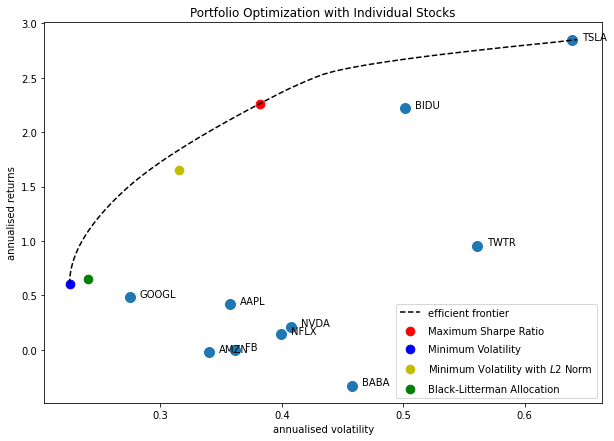

In [12]:
display_simulated_ef_with_random(mean_returns, cov_matrix, 
                                 num_portfolios, risk_free_rate)